In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib notebook

#load the files
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

#size of training dataset
train_samples = train.shape[0]

In [2]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [3]:
train.Embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [4]:
X_train = train[['Pclass','Age','SibSp','Parch','Fare','Sex', 'Embarked']]
y_train = train[['Survived']]

# feature engineering
X_train = X_train.fillna(X_train.mean()) #(method='ffill')
X_train.Sex = X_train.Sex.map({'female':1, 'male':0})
X_train.Embarked.fillna('U', inplace=True)
X_train.Embarked = X_train.Embarked.map({'S':0,'C':1,'Q':2,'U':3})

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Note the way of scalin (df[df.columns])
# we want to mantain the dataframe (instead of numpy array)
X_train[X_train.columns] = MinMaxScaler().fit_transform(X_train[X_train.columns])

<IPython.core.display.Javascript object>


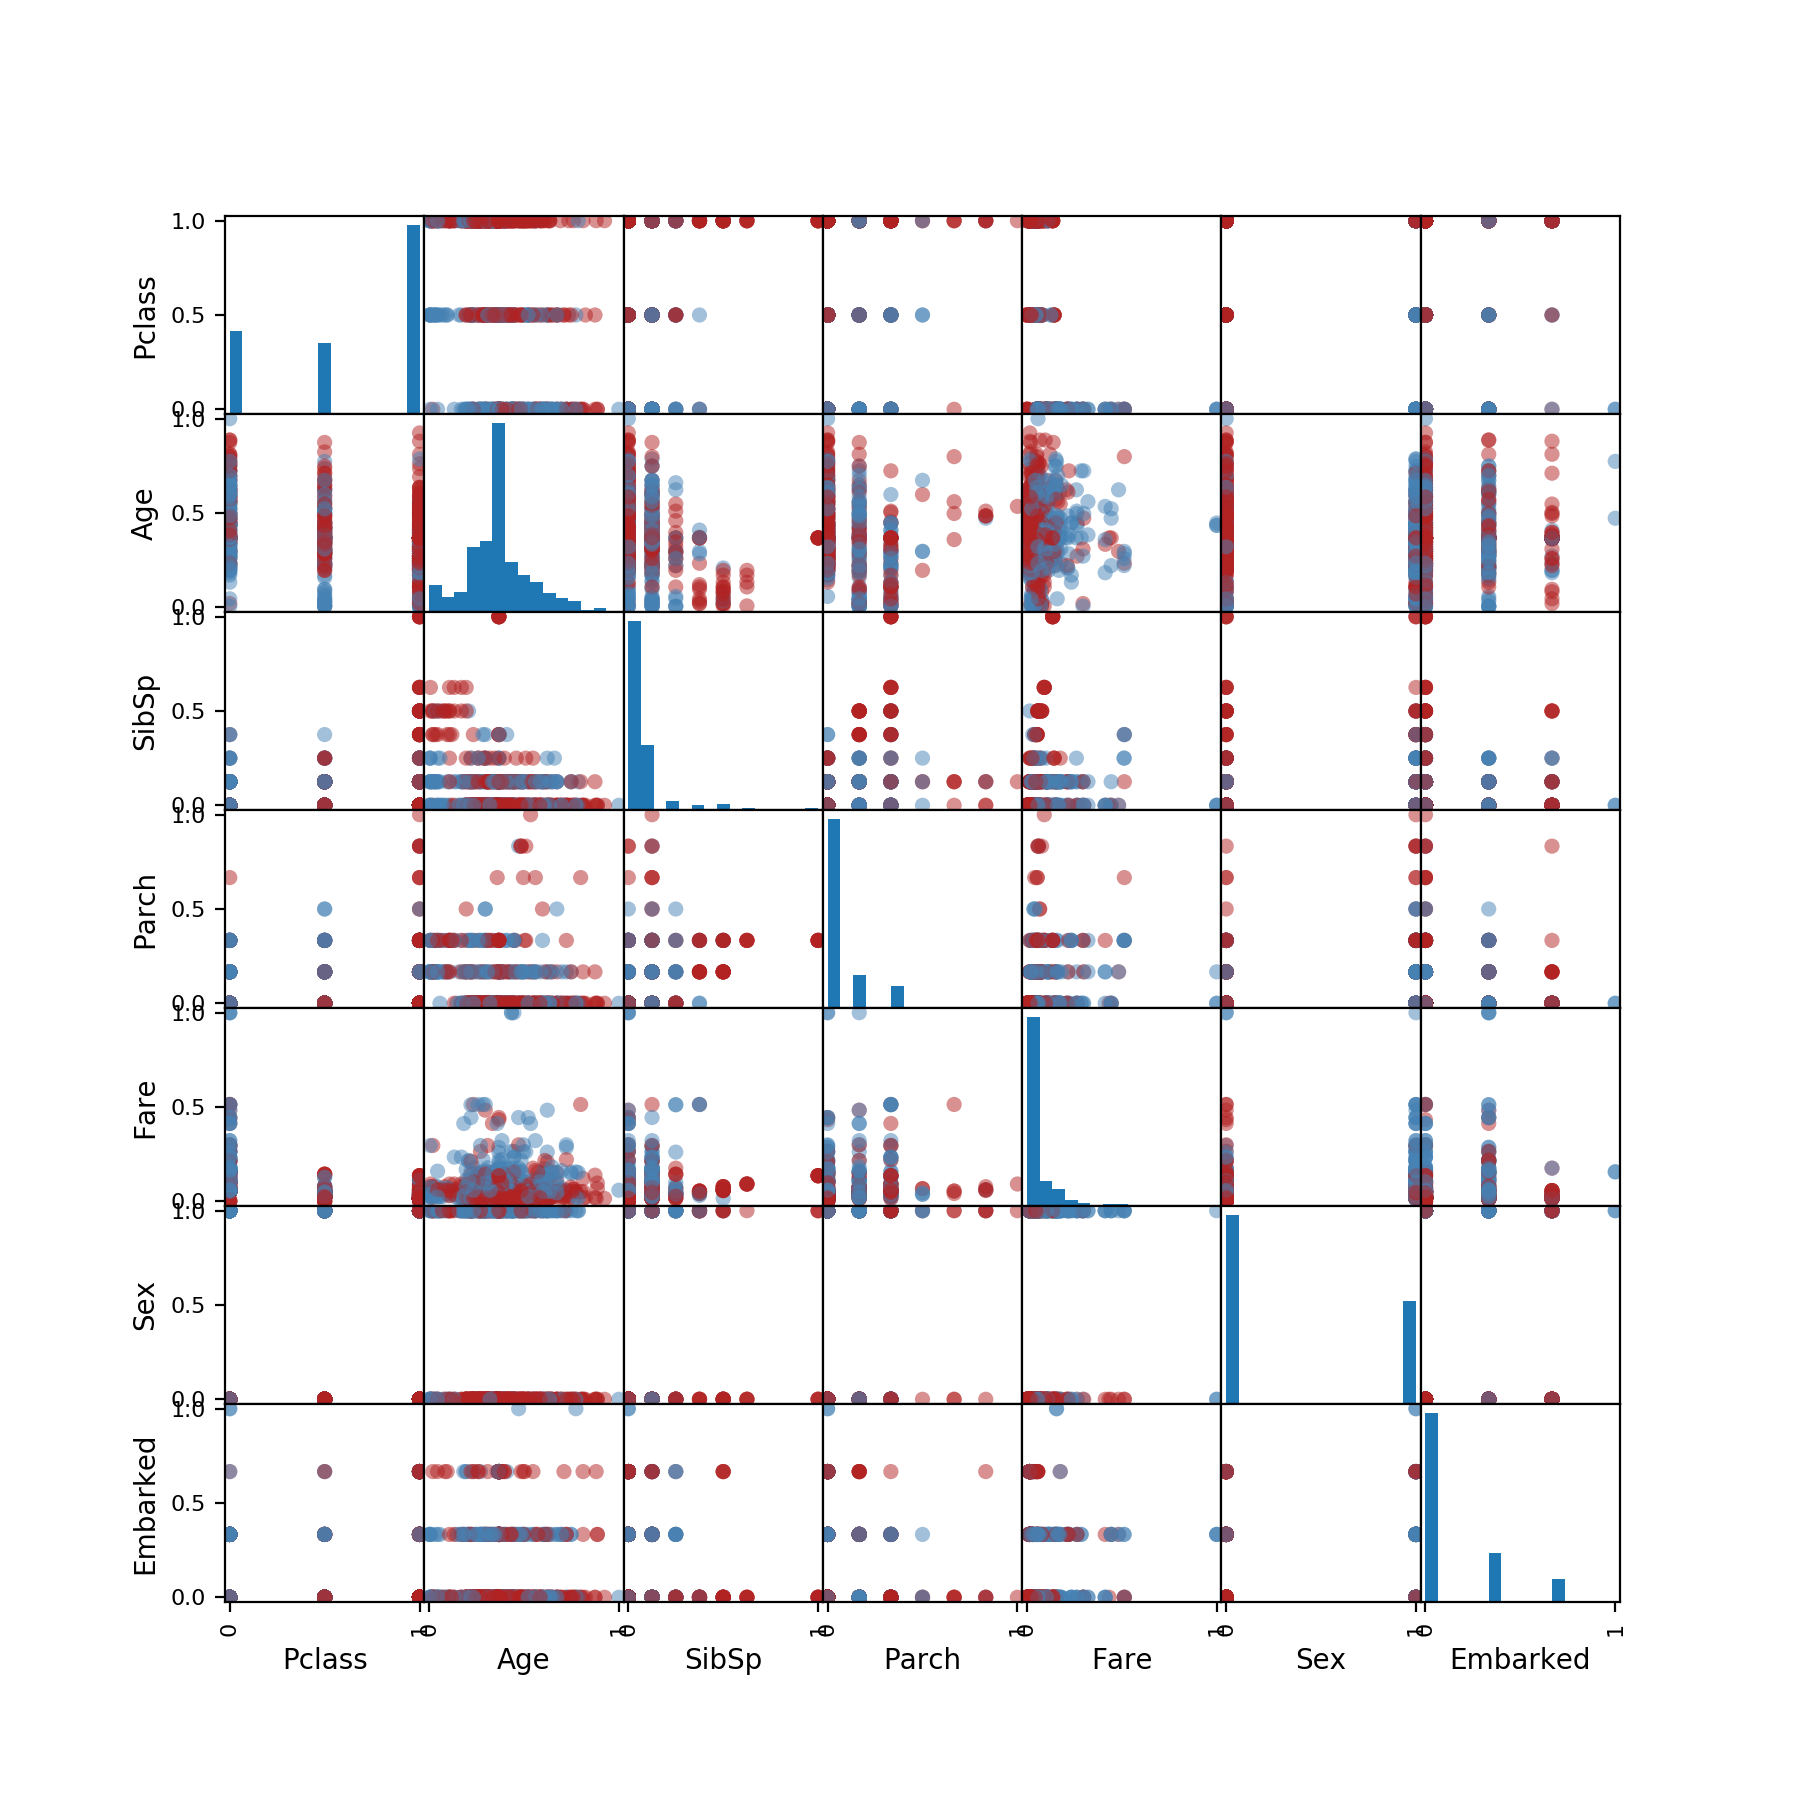

In [6]:
# plotting a scatter matrix
colormap = {0:'firebrick',1:'steelblue'}
colors = y_train.Survived.map(colormap)

pd.plotting.scatter_matrix(X_train, c=colors, marker = 'o', s=30,
                           hist_kwds={'bins':15}, figsize=(9,9));



In [15]:
#baseline
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

def baseline(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)

    dummy = DummyClassifier(random_state=0)

    #be aware of y as column vector
    dummy.fit(X_train, y_train.values.reshape(-1))
    acc = dummy.score(X_val.values, y_val.values.reshape(-1))
    print('Accuracy: {:.2f}\n'.format(acc))
    
    # Combined report with all above metrics
    print(classification_report(y_val, dummy.predict(X_val), target_names=['Not Survived', 'Survived']))

baseline(X_train, y_train)

Accuracy: 0.54

              precision    recall  f1-score   support

Not Survived       0.63      0.62      0.63       139
    Survived       0.39      0.40      0.40        84

 avg / total       0.54      0.54      0.54       223



In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

X_train_1 = X_train[['Pclass','Sex','Parch']].values
y_train_1 = y_train.values.reshape(-1)

rfc = RandomForestClassifier()
scores = cross_validate(rfc, X_train_1, y_train_1, cv=10, scoring='accuracy')

print("Train scores:{}".format(scores['train_score']))
print("Test scores:{}".format(scores['test_score']))

Train scores:[ 0.80898876  0.80649189  0.80922693  0.79800499  0.80548628  0.8117207
  0.8042394   0.8117207   0.80299252  0.80697385]
Test scores:[ 0.77777778  0.8         0.76404494  0.86516854  0.78651685  0.75280899
  0.82022472  0.74157303  0.83146067  0.77272727]
